# Disclaimer
### **This notebook is made for research purposes and should not be taken as advice for any financial action!

In this project we want to predict Tesla's stock price using 3 different learning objectives, Lstm, Arima and Prophet.


## Data

In [1]:
import pandas as pd
from stock_prediction.yfinance_data import StockData
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [33]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2024-01-01")
data = tsla.get_historical_symbol_data().reset_index()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Adj Close,Open,High,Low,Close,Volume
0,2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
1,2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2,2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
3,2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
4,2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [34]:
data.shape

(917, 7)

In [35]:
data.describe()

,Date,Adj Close,Open,High,Low,Close,Volume
count,917,917.000000,917.000000,917.000000,917.000000,917.000000,9.170000e+02
mean,2021-10-26 22:25:46.782988032,205.877666,205.972268,210.727154,200.800992,205.877666,1.345266e+08
min,2020-01-02 00:00:00,24.080000,24.980000,26.990000,23.370000,24.080000,2.940180e+07
25%,2020-11-27 00:00:00,144.670000,146.150000,149.000000,141.500000,144.670000,7.443810e+07
50%,2021-10-26 00:00:00,218.860000,219.400000,223.110000,213.200000,218.860000,1.036743e+08
75%,2022-09-23 00:00:00,266.920000,268.000000,273.170000,261.130000,266.920000,1.668759e+08
max,2023-08-23 00:00:00,409.970000,411.470000,414.500000,405.670000,409.970000,9.140820e+08
std,NaN,89.025945,89.245311,91.038453,87.104351,89.025945,9.255233e+07


### As we can see the price has significantly risen over the past few years
### Our first learning objective will be Arima Model, so lets see if this method could be be

In [36]:
data.shape

(917, 7)

In [37]:
data.describe()

,Date,Adj Close,Open,High,Low,Close,Volume
count,917,917.000000,917.000000,917.000000,917.000000,917.000000,9.170000e+02
mean,2021-10-26 22:25:46.782988032,205.877666,205.972268,210.727154,200.800992,205.877666,1.345266e+08
min,2020-01-02 00:00:00,24.080000,24.980000,26.990000,23.370000,24.080000,2.940180e+07
25%,2020-11-27 00:00:00,144.670000,146.150000,149.000000,141.500000,144.670000,7.443810e+07
50%,2021-10-26 00:00:00,218.860000,219.400000,223.110000,213.200000,218.860000,1.036743e+08
75%,2022-09-23 00:00:00,266.920000,268.000000,273.170000,261.130000,266.920000,1.668759e+08
max,2023-08-23 00:00:00,409.970000,411.470000,414.500000,405.670000,409.970000,9.140820e+08
std,NaN,89.025945,89.245311,91.038453,87.104351,89.025945,9.255233e+07


### As we can see the price has significantly risen over the past few years
### Our first learning objective will be Arima Model, so lets see if this method could be be some Autocorrelation in our data

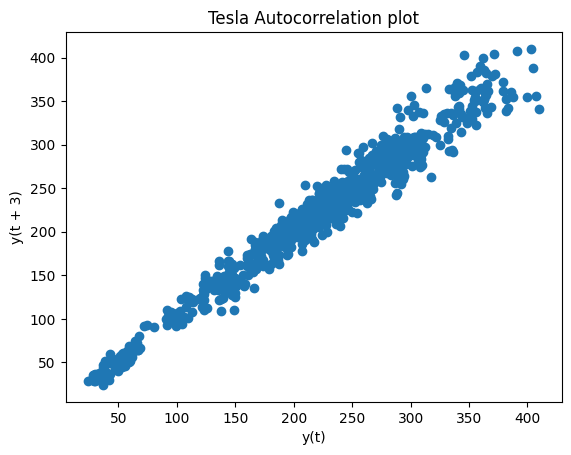

In [38]:
plt.figure()
lag_plot(data['Close'], lag=3)
plt.title('Tesla Autocorrelation plot')
plt.show()

### Looks like our data has a strong correlation between the close price as time 't+3' to its past close price at time 't' 
### Thats a good news for our Arima model

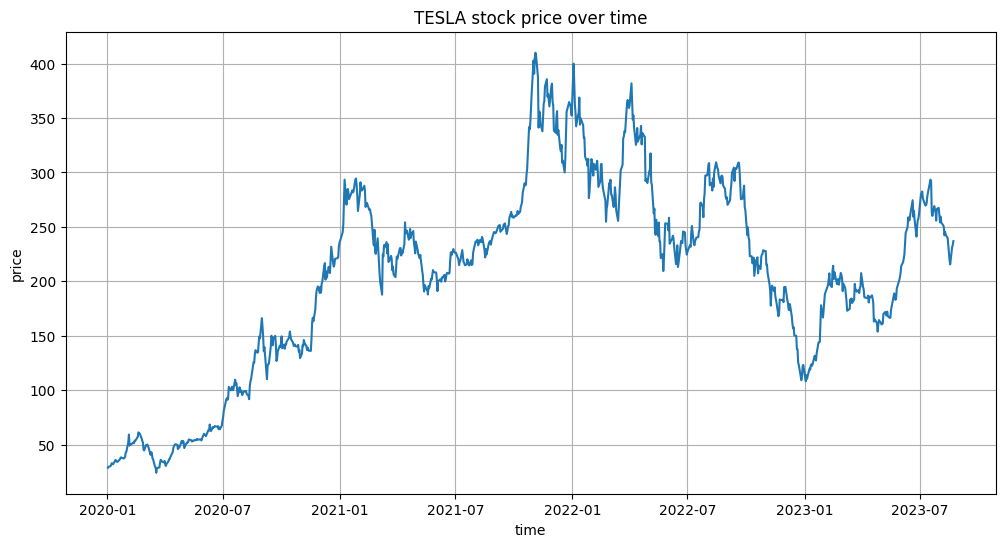

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Close"])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show()

# Arima Model Trainning

In [40]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data['Close'].to_frame()

In [41]:
data

,Close
Date,
2020-01-02,28.68
2020-01-03,29.53
2020-01-06,30.10
2020-01-07,31.27
2020-01-08,32.81
...,...
2023-08-17,219.22
2023-08-18,215.49
2023-08-21,231.28


In [42]:
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = data.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [43]:
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

In [44]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error (MSE): 50.695656521739146
Mean Absolute Error (MAE): 5.4698913043478266
R2 Score: 0.9756996009439319


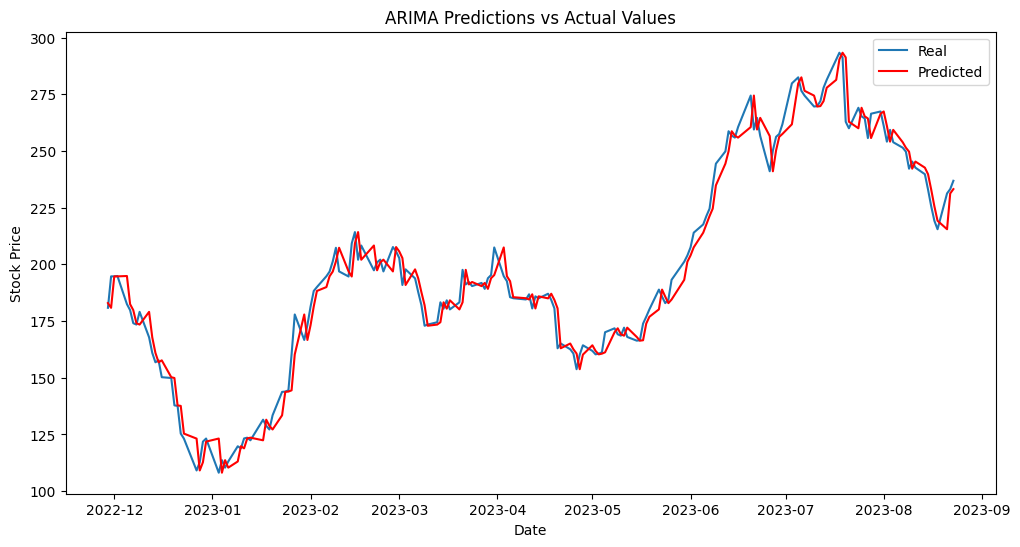

In [45]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(data.iloc[size:,:].index, test, label='Real')
plt.plot(data.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Learning Objective 2: LSTM

In [46]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2023-12-31")
data = tsla.get_historical_symbol_data()
data.head()


[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [47]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2022'].iloc[:,0:1].values
    ts_test  = all_data['2023':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2022'], all_data["Adj Close"]['2023':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [48]:
X_train, y_train, X_test, sc = ts_train_test_normalize(data,5,2)

In [49]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = data.loc['2023':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

5/5 [==============================] - 0s 1ms/step


(156.32817, <Axes: xlabel='Date'>)

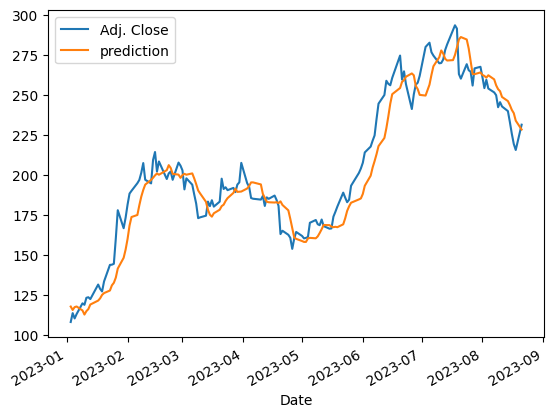

In [50]:

def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)   

# Learning Objective 3: SARIMA

In [16]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2023-7-31")
data = tsla.get_historical_symbol_data()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [4]:
# Resample the data to the monthly level
monthly_mean = data['Adj Close'].resample('M').mean()

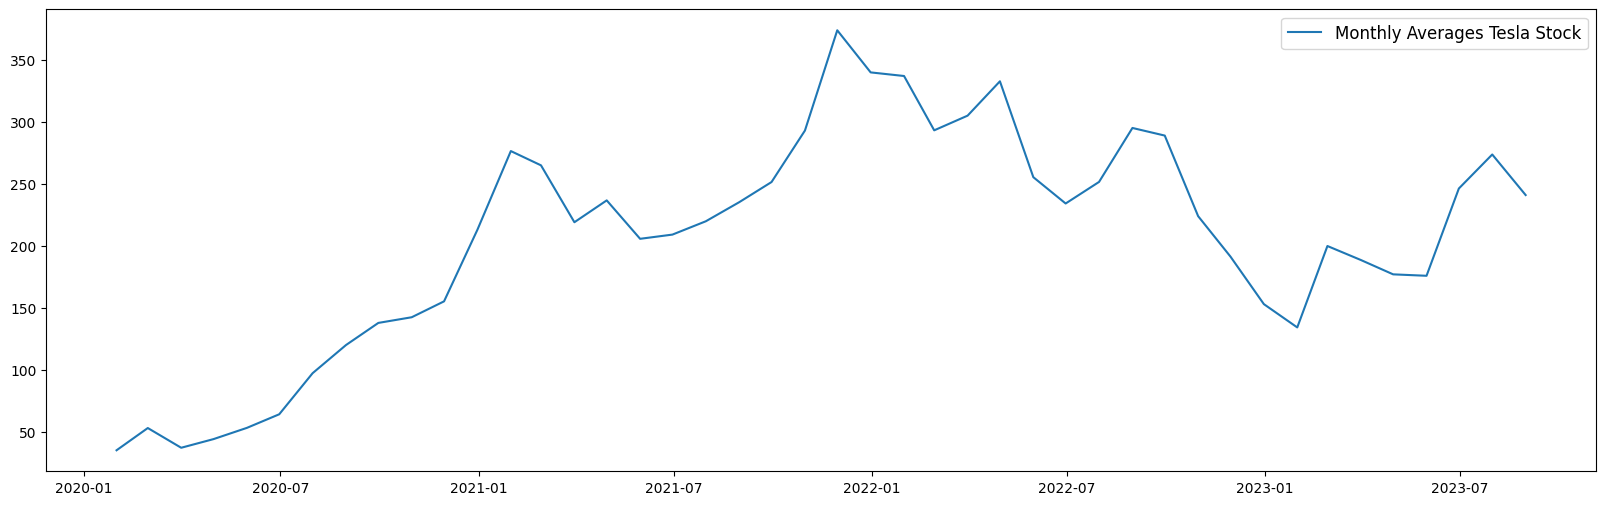

In [5]:
monthly_data = monthly_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages Tesla Stock')
plt.legend(prop={'size': 12})
plt.show()

# Decomposition of Time Series

<Figure size 2000x1200 with 0 Axes>

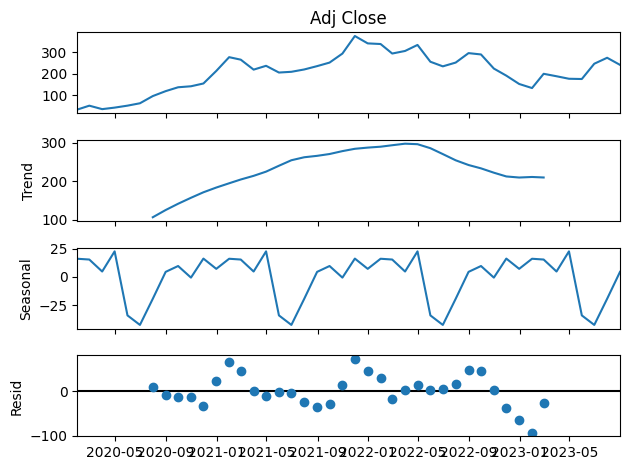

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

plt.figure(figsize=(20,12))
decomposed_series = sd(monthly_data['Adj Close'])
decomposed_series.plot()
plt.show()

## Inferences:
### Trend : Overall an Upward Trend
### Seasonality :There appears to be seasonality. 
### TESLA has rallied during the Holiday season as expected. Since Holiday period has good sales for Apple Over the Years.

<Axes: xlabel='Date'>

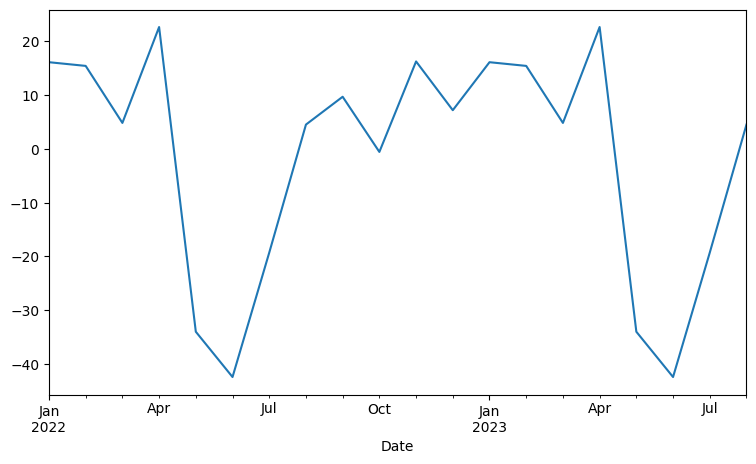

In [7]:
fig = plt.figure(figsize=(9,5))
decomposed_series.seasonal['2022':'2023'].plot()

In [8]:
from statsmodels.tsa.stattools import adfuller

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
   print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis- Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis- Time Series is Non-Stationary')

ad_fuller_func(monthly_data['Adj Close'])

ADF Statistic: -2.151637
p-value: 0.224264
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605
Failed to Reject Null Hypothesis- Time Series is Non-Stationary


# Transformation to make series stationary
### We will use First Order Differencing to detrend the series

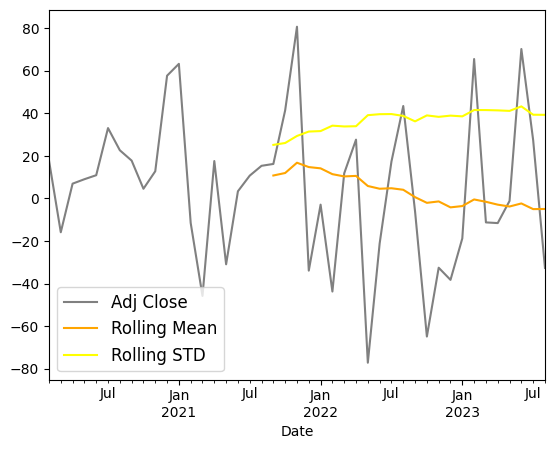

In [9]:
monthly_diff = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [10]:
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -4.991545
p-value: 0.000023
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
Reject Null Hypothesis- Time Series is Stationary


# Observation
The series looks stationary as its having constant mean and variance

# SARIMA
### P: Seasonal autoregressive order.
### D: Seasonal difference order.
### Q: Seasonal moving average order.
### m: The number of time steps for a single seasonal period.

Observations: 368
Training Observations: 185
Testing Observations: 183
Observations: 551
Training Observations: 368
Testing Observations: 183
Observations: 734
Training Observations: 551
Testing Observations: 183
Observations: 917
Training Observations: 734
Testing Observations: 183


<Figure size 640x480 with 0 Axes>

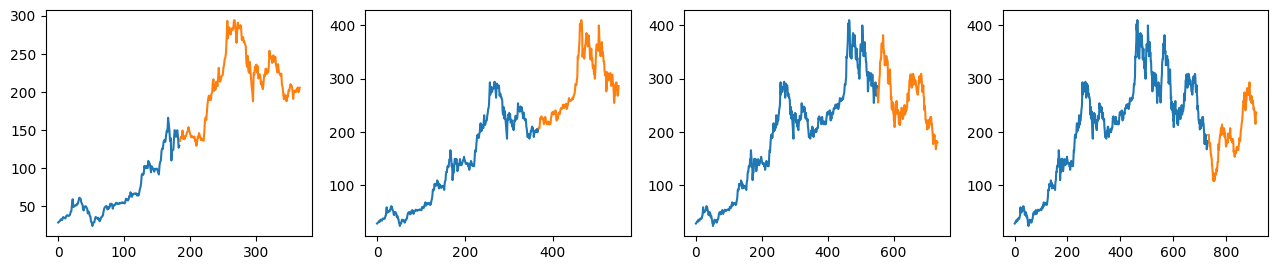

In [11]:
time_series_splits = TimeSeriesSplit(n_splits=4)
X = data["Adj Close"].values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
for train_index, test_index in time_series_splits.split(X):
 train = X[train_index]
 test = X[test_index]
 print('Observations: %d' % (len(train) + len(test)))
 print('Training Observations: %d' % (len(train)))
 print('Testing Observations: %d' % (len(test)))
    
 plt.subplot(360 + index)
 plt.plot(train)
 plt.plot([None for i in train] + [x for x in test])
    # pyplot.title(''.format())
 index += 1
plt.show();

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13798D+00    |proj g|=  2.32168D+00

At iterate    5    f=  4.03825D+00    |proj g|=  2.85166D-02

At iterate   10    f=  3.88637D+00    |proj g|=  1.58916D-03

At iterate   15    f=  3.88201D+00    |proj g|=  4.44802D-02

At iterate   20    f=  3.87561D+00    |proj g|=  2.23684D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.559D-06   3.876D+00
  F =   3.8756055692541471     

CONVERG

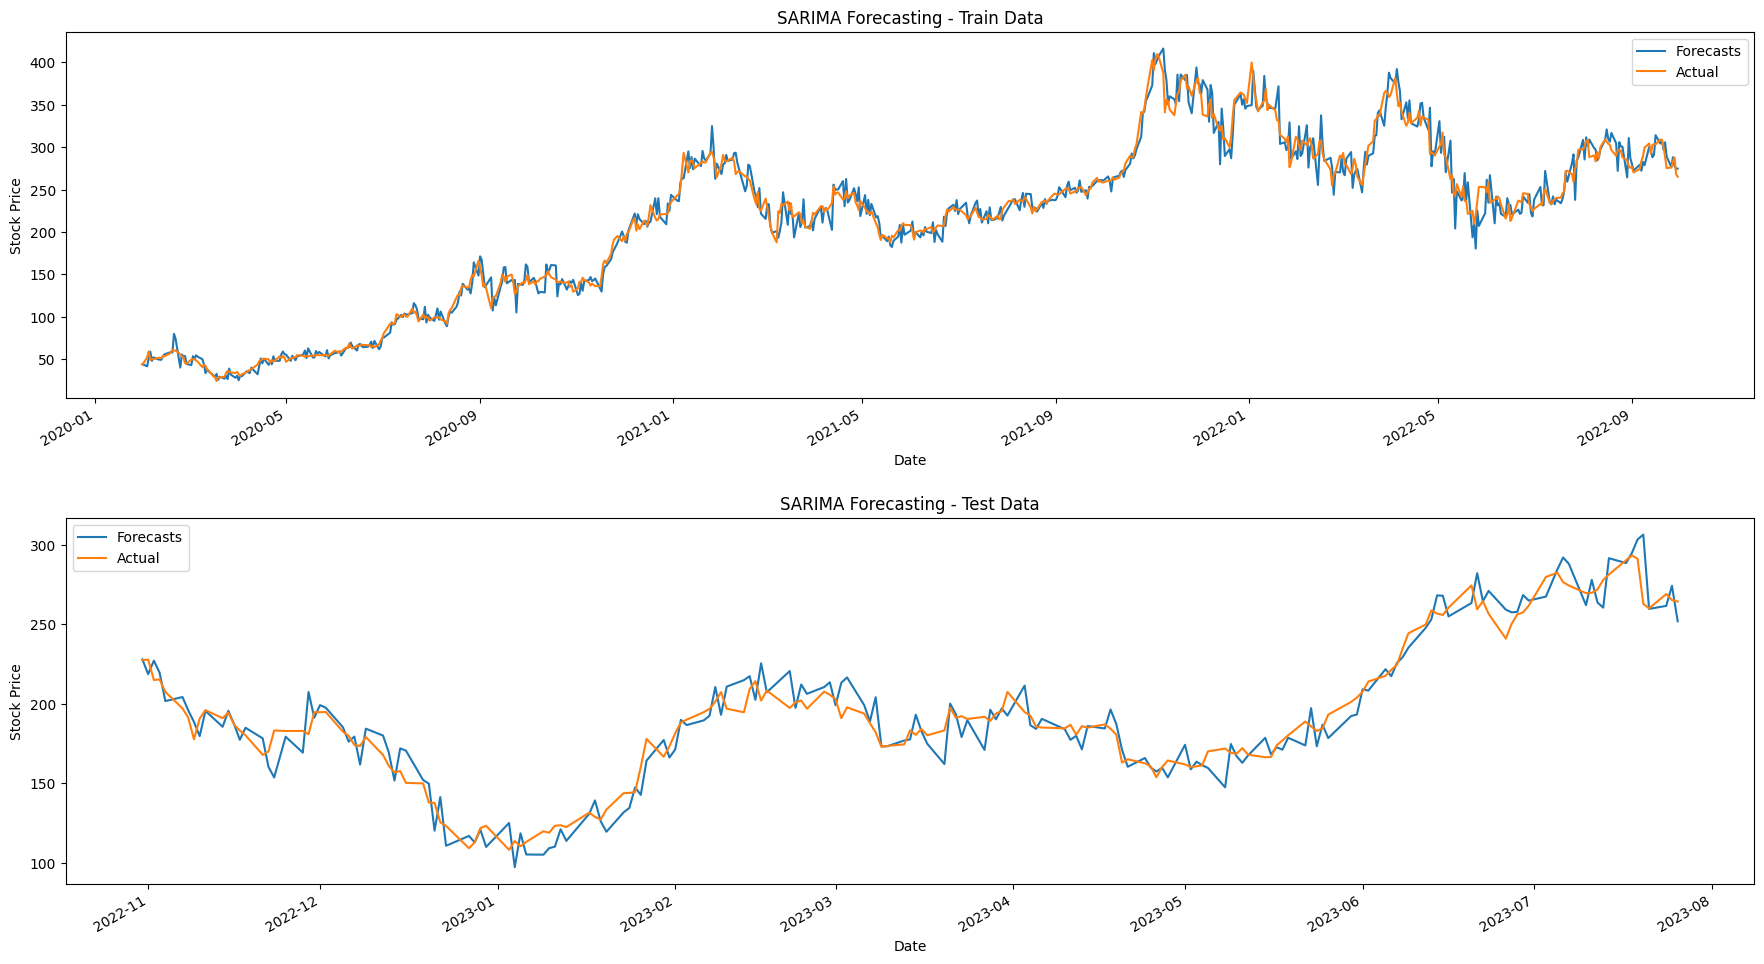

In [18]:
modelling_series = data["Adj Close"]
modelling_series.index = pd.to_datetime(modelling_series.index)

# SARIMA model
model = sm.tsa.SARIMAX(modelling_series, order=(1,1,1), seasonal_order=(2,2,0,12))
results = model.fit()

# Define date ranges
sd = '2020-01-31'
ed = '2022-09-30'
sd2 = '2022-10-31'
ed2 = '2023-7-26'

# Make predictions
forecasts_train = results.predict(start=pd.to_datetime(sd), end=pd.to_datetime(ed))
forecasts_test = results.predict(start=pd.to_datetime(sd2), end=pd.to_datetime(ed2))

# Plotting
fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 10))

forecasts_train.plot(label='Forecasts', ax=ax1, title='SARIMA Forecasting - Train Data')
modelling_series.loc[sd:ed].plot(label='Actual', ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts', ax=ax2, title='SARIMA Forecasting - Test Data')
modelling_series.loc[sd2:ed2].plot(label='Actual', ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)
plt.show()